In [1]:
import os

import pandas as pd
from clearml import Task

import matplotlib.pyplot as plt
import seaborn as sns

# Utils

In [2]:
# project_name = 'AA_attack_run_GOLDEN'
# #project_name = 'attacks_examples'
# tags_filter = ["__$all", 'Dima', 'Strawberry']
# tags_filter = []

# tags_iteration = [['Dmitry'], ['Sophie']]
# metrics = pd.DataFrame()

# for tags in tags_iteration:
#     tasks = Task.get_tasks(project_name=project_name, tags=tags)
#     # task_example = tasks[-1]
#     print(len(tasks))

#     metrics_ = pd.DataFrame()

#     for task in tasks:
#         task_name = task.name
#         print(task_name) 
#         scalars = task.get_reported_scalars()
#         # experiments[task_name] = scalars
#         #scalars = [scalar for scalar in scalars scalar]

#         df_all_metrics = pd.DataFrame([])

#         for metric_name in scalars:
#             if metric_name[0] == ':':
#                 continue
#             data = scalars[metric_name][metric_name]
#             iters = data['x']
#             values = data['y']
#             df_metric = pd.DataFrame(index=data['x'], columns=[data['name']], data=data['y'])
#             df_all_metrics = df_all_metrics.join(df_metric, how='right')

#         df_all_metrics = df_all_metrics.reset_index()
#         df_all_metrics = df_all_metrics.rename(columns={'index': 'iters'})
#         df_all_metrics['exp_name'] = task_name
#         metrics_ = pd.concat([metrics_, df_all_metrics])
#     metrics = pd.concat([metrics, metrics_])

# metrics.to_csv('../results/attack_metrics_clearml_3.csv')
# metrics

In [3]:
def draw_scatter_pair_metrics(df, x_col, y_col, x_col_name=None, y_col_name=None, title=None):

    n_colors = df['dataset'].nunique()

    # Цветовая палитра для датасетов
    palette = sns.color_palette("hls", n_colors)

    # Формы точек для моделей
    markers = ['o', 's', 'D', '^', '<', '>']

    plt.figure(figsize=[5, 5])

    # Создание scatterplot
    sns.scatterplot(
        x=x_col, 
        y=y_col, 
        hue='dataset', 
        style='model',
        data=df,
        palette=palette,
        markers=markers,
        s=100
    )

    if not x_col_name:
        x_col_name = x_col
    
    if not y_col_name:
        y_col_name = y_col

    # Настройка графика
    plt.xlabel(x_col_name)
    plt.ylabel(y_col_name)
    plt.xlim(-0.02, 1.02)
    plt.ylim(-0.02, 1.02)

    # Диагональная линия
    plt.plot([0, 1], [0, 1], 'k--')

    if title:
        plt.title(title)

    # Легенда
    plt.legend(title='Model / Dataset', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    # plt.title('Изменение метрики атаки с дискриминатором и без дискриминатора')
    # # Отображение графика
    # plt.tight_layout()
    plt.show()


In [4]:
def load_local_data(datasets, models, prefixes, flag_test=True):
    results = pd.DataFrame()

    for dataset in datasets:
        df_dataset = pd.DataFrame()
        for model in models:
            model_data = pd.DataFrame()
            path = f'../results/{dataset}/{model}/attack'

            try:
                experiments = os.listdir(path)                
                for exp_folder in experiments:
                    if exp_folder[0] == '.':
                        continue
                    exp_path = os.path.join(path, exp_folder)
                    exp_params = [exp for exp in os.listdir(exp_path) if '.csv' in exp]
                    
                    exp_data = pd.DataFrame()
                    for param_file in exp_params:
                        metric_path = os.path.join(exp_path, param_file)
                        param_df = pd.read_csv(metric_path)
                        #print(metric_path)
                        
                        exp_full_name = param_file.replace('.csv', '')
                        # exp_full_name
                        # for prefix in prefixes:

                        #     print(prefix in exp_name)
                        #     exp_name = exp_name.replace(exp_full_name, '')
                        #     while exp_name[-1] == '_':
                        #         exp_name = exp_name[:-1]
                        param_df['full_exp_name'] = exp_full_name
                        
                        param_df.columns = [col.strip() for col in param_df.columns]

                        exp_data = pd.concat([exp_data, param_df], axis=0)
                    
                    exp_name = exp_folder
                    exp_data['experiment'] = exp_name

                    exp_data['model'] = model
                    exp_data['dataset'] = dataset

                    if len(exp_data.columns) > 22 or flag_test:
                        flag_test = False
                    model_data = pd.concat([model_data, exp_data], axis=0)
            except:
                print(path)
            
            df_dataset = pd.concat([df_dataset, model_data], axis=0)
        results = pd.concat([results, df_dataset], axis=0)

    return results

# Load 

In [5]:
# dataset = 'PowerCons'
# model = 'ResidualCNN'

results = load_local_data(
    datasets = ['GunPointMaleVersusFemale', 'Strawberry', 'PowerCons', 'GunPoint'],
    models = ['ResidualCNN', 'PatchTST'], # ['S4', 'ResidualCNN', 'TST', 'PatchTST', 'RNNA']
    prefixes = ['fast_run', 'test'],
    flag_test = True,
)


mask = \
    (results['full_exp_name'].str.contains('pgd')) | \
    (results['full_exp_name'].str.contains('simba')) | \
    (results['full_exp_name'].str.contains('kll2')) | \
    (
        results['full_exp_name'].str.contains('fgsm') & \
        (results['dataset'] == 'PowerCons') & results['model'].isin(['PatchTST', 'ResidualCNN'])
)
results = results[mask].rename(columns={'step_id': 'iters'})
results['exp_name'] = results['full_exp_name']

../results/PowerCons/ResidualCNN/attack
../results/PowerCons/PatchTST/attack
../results/GunPoint/ResidualCNN/attack
../results/GunPoint/PatchTST/attack


In [6]:
res_check = results[~results['full_exp_name'].str.contains('pgd')]

res_check['exp_name'] = res_check['exp_name'].str.replace('__', '|')
res_check['exp_name_no_params'], res_check['exp_params'] = res_check['exp_name'].str.split('|', n=1).str

res_check['exp_params'] = res_check['exp_params'].str.split('|')
res_check['dataset'].unique()

/tmp/ipykernel_133025/3510677327.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_check['exp_name'] = res_check['exp_name'].str.replace('__', '|')
/tmp/ipykernel_133025/3510677327.py:4: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  res_check['exp_name_no_params'], res_check['exp_params'] = res_check['exp_name'].str.split('|', n=1).str
/tmp/ipykernel_133025/3510677327.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_check['exp_name_no_params'], res_c

array(['GunPointMaleVersusFemale', 'Strawberry'], dtype=object)

In [7]:
bad_exp = [exp for exp in res_check.full_exp_name.unique() if len(exp) < 30]
res_check[res_check['full_exp_name'].isin(bad_exp)]['exp_name'].unique()

array([], dtype=object)

# Transform

In [8]:
metrics = pd.read_csv('../results/attack_metrics_clearml_3.csv', index_col=0)

na_mask = metrics.T.isna().sum() > 0
metrics = metrics[~na_mask]

metrics.head()

,iters,ACC,ACC_CORRECT,ACC_DISC,ACC_ORIG_ADV,CONC,EFF,F1,F1_DISC,F_EFF_CONC,L1,PR,PROB_HID,ROC,ROC_AUC_DISC,ROUGHNESS,ROUGHNESS_NORM,exp_name
0,0,0.977895,1.000000,0.982456,1.000000,0.000000,0.022005,0.977995,0.000000,0.000000,0.000000,0.965266,0.021848,0.977895,1.000000,0.044127,1.000000,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
1,1,0.951579,0.973089,0.500175,0.973684,0.509884,0.047553,0.952447,0.034565,0.086994,1.505000,0.922534,0.022083,0.951579,0.490116,0.045802,1.037978,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
2,2,0.918246,0.939003,0.500702,0.940351,0.475143,0.079333,0.920667,0.036561,0.135964,2.775684,0.873987,0.024397,0.918246,0.524857,0.047355,1.073161,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
3,3,0.881404,0.901328,0.501579,0.903509,0.412841,0.114344,0.885656,0.039878,0.179086,4.075333,0.826099,0.029835,0.881404,0.587160,0.049146,1.113756,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001
4,4,0.843860,0.862935,0.503509,0.865965,0.343764,0.151206,0.848794,0.047138,0.210030,5.184747,0.782925,0.041206,0.843860,0.656236,0.051147,1.159093,model_RNNA_100_FreezerRegularTrain_attack_fgsm_disc_attack__eps=0.005__n_steps=50__alpha=0.0001


In [9]:
metrics['iters'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [10]:
metrics = pd.concat([metrics, results])

In [11]:
metrics['exp_name'] = metrics['exp_name'].str.replace('__', '|')
metrics['exp_name_no_params'], metrics['exp_params'] = metrics['exp_name'].str.split('|', n=1).str

metrics['exp_params'] = metrics['exp_params'].str.split('|')
metrics['exp_params'] = metrics['exp_params'].apply(lambda x_list: {x.split('=')[0]:x.split('=')[1] for x in x_list})
metrics = pd.concat([metrics.reset_index(drop=True), pd.json_normalize(metrics['exp_params'])], axis=1)
metrics = metrics.drop(columns=['exp_params'])

metrics['_'], metrics['model'], metrics['seed'], metrics['dataset'], metrics['attack'] = \
    metrics['exp_name_no_params'].str.split('_', n=4).str
metrics = metrics.drop(columns=['_'])

metrics['attack'] = metrics['attack'].apply(
    lambda x: '_'.join([word for word in x.split('_') if word != 'attack'])
)
metrics['attack_type'] = metrics['attack'].str.split('_').str[0]
metrics['disc_attack'] = metrics['attack'].str.contains("disc")

metrics.head()

/tmp/ipykernel_133025/2431537609.py:2: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  metrics['exp_name_no_params'], metrics['exp_params'] = metrics['exp_name'].str.split('|', n=1).str
/tmp/ipykernel_133025/2431537609.py:9: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  metrics['_'], metrics['model'], metrics['seed'], metrics['dataset'], metrics['attack'] = \


,iters,ACC,ACC_CORRECT,ACC_DISC,ACC_ORIG_ADV,CONC,EFF,F1,F1_DISC,F_EFF_CONC,...,n_steps,alpha,eta,smoothness,mu,norm_coef,seed,attack,attack_type,disc_attack
0,0.0,0.977895,1.000000,0.982456,1.000000,0.000000,0.022005,0.977995,0.000000,0.000000,...,50,0.0001,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
1,1.0,0.951579,0.973089,0.500175,0.973684,0.509884,0.047553,0.952447,0.034565,0.086994,...,50,0.0001,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
2,2.0,0.918246,0.939003,0.500702,0.940351,0.475143,0.079333,0.920667,0.036561,0.135964,...,50,0.0001,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
3,3.0,0.881404,0.901328,0.501579,0.903509,0.412841,0.114344,0.885656,0.039878,0.179086,...,50,0.0001,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
4,4.0,0.843860,0.862935,0.503509,0.865965,0.343764,0.151206,0.848794,0.047138,0.210030,...,50,0.0001,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True


In [12]:
hid_col = 'F1'
conc_col = 'F1_DISC'

metrics['EFF'] = 1 - metrics[hid_col]
metrics['CONC'] = 1 - metrics[conc_col]
metrics['F_EFF_CONC'] = 2 * metrics['EFF']  * metrics['CONC'] / (metrics['EFF'] + metrics['CONC'])

In [13]:
mask = (metrics['model'] == 'ResidualCNN') & (metrics['dataset'] == 'PowerCons') # & (metrics['attack'] == 'fgsm')
metrics[mask]['attack'].unique()

array(['fgsm_harmonic', 'fgsm'], dtype=object)

# Vizualization

In [14]:
metrics.head()

,iters,ACC,ACC_CORRECT,ACC_DISC,ACC_ORIG_ADV,CONC,EFF,F1,F1_DISC,F_EFF_CONC,...,n_steps,alpha,eta,smoothness,mu,norm_coef,seed,attack,attack_type,disc_attack
0,0.0,0.977895,1.000000,0.982456,1.000000,1.000000,0.022005,0.977995,0.000000,0.043062,...,50,0.0001,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
1,1.0,0.951579,0.973089,0.500175,0.973684,0.965435,0.047553,0.952447,0.034565,0.090642,...,50,0.0001,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
2,2.0,0.918246,0.939003,0.500702,0.940351,0.963439,0.079333,0.920667,0.036561,0.146594,...,50,0.0001,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
3,3.0,0.881404,0.901328,0.501579,0.903509,0.960122,0.114344,0.885656,0.039878,0.204351,...,50,0.0001,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True
4,4.0,0.843860,0.862935,0.503509,0.865965,0.952862,0.151206,0.848794,0.047138,0.260996,...,50,0.0001,NaN,NaN,NaN,NaN,100,fgsm_disc,fgsm,True


In [15]:
metric_name = 'F_EFF_CONC'

eff_thr = 0.9
pgd_fgsm_iter_thr = 40
simba_iter_thr = 1200
kll2_iter_thr = 350

filter_start_point_mask = (metrics['EFF'] > eff_thr) | \
    (((metrics['attack'].str.contains('fgsm')) |  (metrics['attack'].str.contains('pgd'))) & (metrics['iters'] >= pgd_fgsm_iter_thr)) | \
    ((metrics['attack'].str.contains('simba')) & (metrics['iters'] >= simba_iter_thr)) | \
    ((metrics['attack'].str.contains('kll2')) & (metrics['iters'] >= kll2_iter_thr))

agg_data = metrics[filter_start_point_mask].groupby(by=['dataset', 'model', 'attack'], as_index=False).agg({metric_name: max})
agg_data = agg_data.pivot(index=['dataset', 'model'], columns='attack', values=metric_name).reset_index()
# agg_data = agg_data.dropna(subset=['fgsm', 'fgsm_disc'])
agg_data

attack,dataset,model,fgsm,fgsm_disc,fgsm_harmonic,kll2,pgd,pgd_disc
0,Coffee,PatchTST,0.464286,1.000000,1.000000,NaN,NaN,NaN
1,Coffee,RNNA,0.661935,1.000000,1.000000,NaN,NaN,NaN
2,Coffee,ResidualCNN,1.000000,1.000000,1.000000,NaN,NaN,NaN
3,Coffee,S4,0.892537,1.000000,1.000000,NaN,NaN,NaN
4,FreezerRegularTrain,PatchTST,0.051125,0.999649,0.995091,NaN,NaN,NaN
5,FreezerRegularTrain,RNNA,0.075926,0.943598,NaN,NaN,NaN,NaN
6,FreezerRegularTrain,ResidualCNN,0.996297,0.997156,0.994310,NaN,NaN,NaN
7,FreezerRegularTrain,S4,0.089920,0.951026,NaN,NaN,NaN,NaN
8,GunPoint,PatchTST,0.019608,0.802195,0.767375,NaN,NaN,NaN
9,GunPoint,RNNA,0.013158,0.512798,0.459635,NaN,NaN,NaN


/tmp/ipykernel_125493/1096806494.py:14: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(


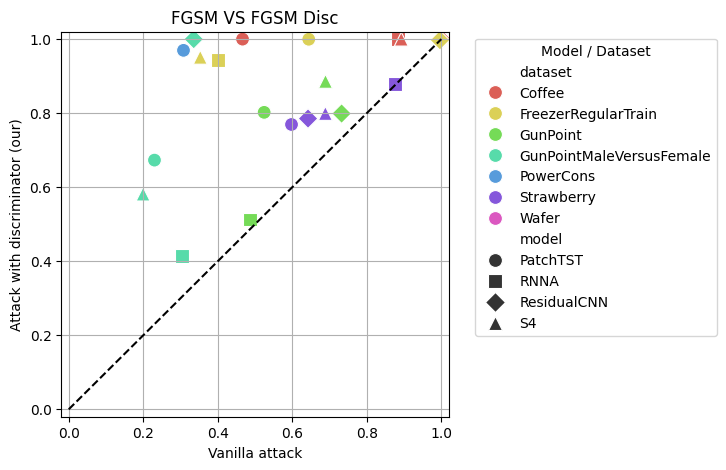

In [14]:
draw_scatter_pair_metrics(agg_data, 'fgsm', 'fgsm_disc', x_col_name='Vanilla attack', y_col_name='Attack with discriminator (our)', title='FGSM VS FGSM Disc')

/tmp/ipykernel_125493/1096806494.py:14: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(


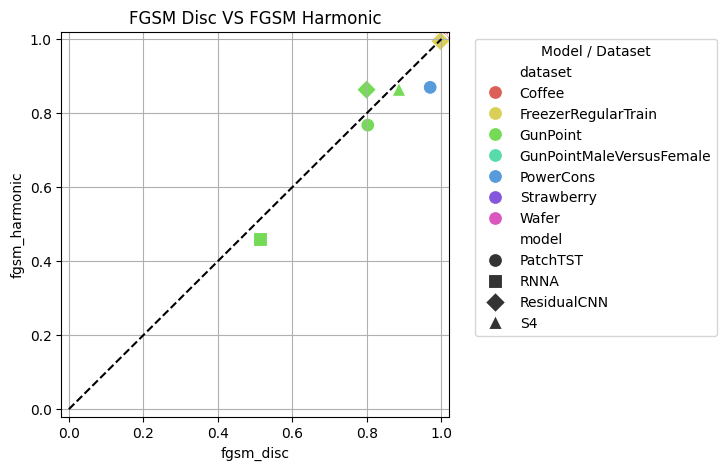

In [15]:
draw_scatter_pair_metrics(agg_data, 'fgsm_disc', 'fgsm_harmonic', title='FGSM Disc VS FGSM Harmonic')

In [17]:
# draw_scatter_pair_metrics(agg_data, 'fgsm_disc', 'fgsm_disc_hypercones', title='FGSM Disc VS FGSM Hypercones')

/tmp/ipykernel_988480/1096806494.py:14: UserWarning: The markers list has more values (6) than needed (4), which may not be intended.
  sns.scatterplot(


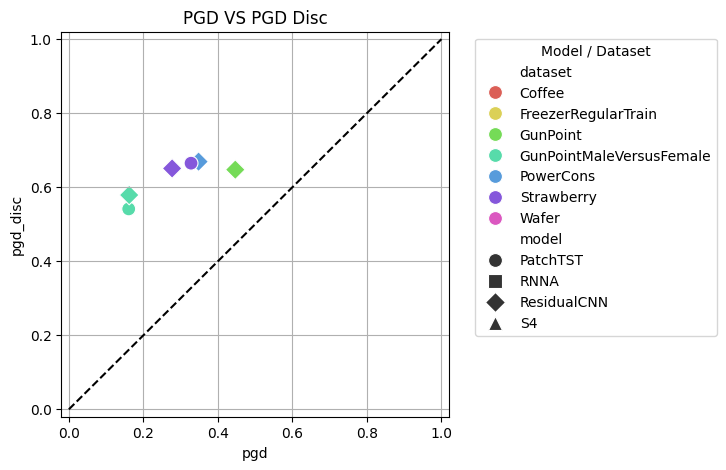

In [17]:
draw_scatter_pair_metrics(agg_data, 'pgd', 'pgd_disc', title='PGD VS PGD Disc')

In [18]:
metric_name = 'F_EFF_CONC'

agg_data = metrics.groupby(by=['dataset', 'model', 'attack'], as_index=False).agg({'EFF': 'max', 'CONC': 'max'})
# agg_data = agg_data.pivot(index=['dataset', 'model'], columns='attack', values=metric_name).reset_index()
# agg_data = agg_data.dropna(subset=['fgsm', 'fgsm_disc'])
agg_data

,dataset,model,attack,EFF,CONC
0,Coffee,PatchTST,fgsm,1.000000,1.0
1,Coffee,PatchTST,fgsm_disc,1.000000,1.0
2,Coffee,PatchTST,fgsm_harmonic,1.000000,1.0
3,Coffee,RNNA,fgsm,1.000000,1.0
4,Coffee,RNNA,fgsm_disc,1.000000,1.0
...,...,...,...,...,...
66,Strawberry,ResidualCNN,pgd,1.000000,1.0
67,Strawberry,ResidualCNN,pgd_disc,1.000000,1.0
68,Strawberry,S4,fgsm,0.778846,1.0
69,Strawberry,S4,fgsm_disc,0.927083,1.0


In [18]:
# attacks_to_save = ['fgsm', 'fgsm_disc']

# df = agg_data[agg_data['attack'].isin(attacks_to_save)]
# sns.scatterplot(df, x='CONC', y='EFF', hue='attack')

In [ ]:
raise ValueError

# Examples

In [ ]:
# changing core directory
import os
import sys

dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if dir1 not in sys.path:
    sys.path.append(dir1)
os.chdir('..')

In [ ]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# from src.attacks import fgsm_attack, only_disc_attack
# from src.attacks.utils import calculate_metrics_class_and_hiddens, req_grad
from src.config import get_disc_list
from src.data import MyDataset, load_data, transform_data
from src.models.LSTM import LSTM
# from src.utils import load_disc_model

In [ ]:
from hydra import compose, initialize
from omegaconf import OmegaConf
initialize(config_path='../config', version_base=None)
cfg = compose(config_name='attack_run_config.yaml')
print(OmegaConf.to_yaml(cfg))

In [ ]:
import os
import warnings

import hydra
import pandas as pd
import torch
from omegaconf import DictConfig
from torch.utils.data import DataLoader

from src.config import get_attack, get_criterion, get_disc_list, get_model
from src.data import MyDataset, load_data, transform_data
from src.estimation.estimators import AttackEstimator
from src.utils import save_experiment

In [ ]:
X_train, y_train, X_test, y_test = load_data(cfg['dataset'])
X_train, X_test, y_train, y_test = transform_data(X_train, X_test, y_train, y_test, slice_data=cfg['slice'])

test_loader = DataLoader(
    MyDataset(X_test, y_test), 
    batch_size=cfg['batch_size'] , 
    shuffle=True
    )


device = torch.device(cfg["cuda"] if torch.cuda.is_available() else "cpu")

attack_model_path = os.path.join(
    cfg["model_folder"],
    cfg["attack_model"]["name"],
    f"model_{cfg['model_id_attack']}_{cfg['dataset']}.pt",
)

attack_model = get_model(
    cfg["attack_model"]["name"],
    cfg["attack_model"]["params"],
    path=attack_model_path,
    device=device,
    train_mode=cfg["attack_model"]["attack_train_mode"],
)

In [ ]:
criterion = get_criterion(cfg["criterion_name"], cfg["criterion_params"])

disc_check_list = (
    get_disc_list(
        model_name=cfg["disc_model_check"]["name"],
        model_params=cfg["disc_model_check"]["params"],
        list_disc_params=cfg["list_check_model_params"],
        device=device,
        path=cfg["disc_path"],
        train_mode=False,
    )
    if cfg["use_disc_check"]
    else None
)
estimator = AttackEstimator(disc_check_list, cfg["metric_effect"])

In [ ]:
alpha = 1
eps = 0.03

In [ ]:
attack_metrics = pd.DataFrame()
attack_params = dict(cfg["attack"]["attack_params"])
attack_params["model"] = attack_model
attack_params["criterion"] = criterion
attack_params["estimator"] = estimator
attack_params["alpha"] = alpha
attack_params["eps"] = eps

if "list_reg_model_params" in cfg["attack"]:
    attack_params["disc_models"] = get_disc_list(
        model_name=cfg["disc_model_reg"]["name"],
        model_params=cfg["disc_model_reg"]["params"],
        list_disc_params=cfg["attack"]["list_reg_model_params"],
        device=device,
        path=cfg["disc_path"],
        train_mode=cfg["disc_model_reg"]["attack_train_mode"],
    )

attack = get_attack(cfg["attack"]["name"], attack_params)
X_adv = attack.apply_attack(test_loader).squeeze(-1)

results = attack.get_metrics()
results["eps"] = eps
attack_metrics = pd.concat([attack_metrics, results])